In [17]:
import os
import math
import time
import argparse
from tqdm import tqdm

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as d
from classifier.AttributeClassifier import AttributeClassifier
from classifier.LargeScaleAttributesDataset import LargeScaleAttributesDataset
import classifier.utils as u
from torchvision import transforms
from torchsummary import summary
from classifier.Predictor import AttributeClassifierInference
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
dataset_root = '../data/largescale/'
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

In [57]:
tf = transforms.Compose([ transforms.RandomResizedCrop(229), transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize ])
full_dataset = LargeScaleAttributesDataset( attributes_file=os.path.join(dataset_root, 'LAD_annotations/attributes.txt'),
                                            attributes_list=os.path.join(dataset_root, 'LAD_annotations/attribute_list.txt'),
                                            label_list= os.path.join(dataset_root, 'LAD_annotations/label_list.txt'),
                                            root_dir=dataset_root,
                                            transform=tf)
full_dataset_no_process = LargeScaleAttributesDataset( attributes_file=os.path.join(dataset_root, 'LAD_annotations/attributes.txt'),
                                            attributes_list=os.path.join(dataset_root, 'LAD_annotations/attribute_list.txt'),
                                            label_list= os.path.join(dataset_root, 'LAD_annotations/label_list.txt'),
                                            root_dir=dataset_root)
transform_numpy = transforms.ToPILImage()

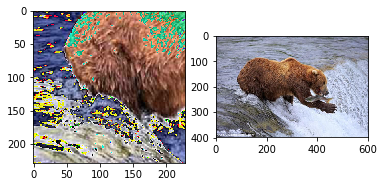

In [140]:
index = 50
annotation = image = full_dataset[index]['attributes']
image = full_dataset[index]['image']
image_no_process = full_dataset_no_process[index]['image']
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(transform_numpy(image))
f.add_subplot(1,2, 2)
plt.imshow(image_no_process)
plt.show(block=True)

In [141]:
checkpoint = torch.load('./focal_model_2_finetune_2c.chkpt', map_location='cpu')
classifier = AttributeClassifier(out_features=359, device='cpu')
classifier.load_state_dict(checkpoint['model'], strict=False)
predictor = AttributeClassifierInference(attribute_classifier=classifier, device='cpu')

In [142]:
pred = predictor(image.unsqueeze(0)).squeeze(0).detach().numpy()
ann = annotation.numpy()
print(pred)
print(ann)

num_correct_and_one = (ann == pred)
print(np.sum(num_correct_and_one), 'out of', len(ann))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [146]:
import torch.utils.data as d
data = d.DataLoader(full_dataset, batch_size=32, shuffle=True, drop_last=False, num_workers=2)

In [149]:
# Per attribute accuracy
total = 0
per_attribute = np.zeros_like(annotation.numpy())
for batch in tqdm(data, mininterval=2, desc='  - (Eval)   ', leave=False):
    x, y = batch['image'], batch['attributes']
    preds = predictor(x)
    correct_classes = y == preds
    total += correct_classes.shape[0]
    per_attribute += correct_classes
    if total > 500:
        break

per_attribute_statistics = per_attribute / total
print(per_attribute_statistics)



  - (Eval)   :   0%|          | 0/144 [00:00<?, ?it/s]

  - (Eval)   :   1%|          | 1/144 [00:04<11:46,  4.94s/it]

  - (Eval)   :   1%|▏         | 2/144 [00:08<10:42,  4.52s/it]

  - (Eval)   :   2%|▏         | 3/144 [00:12<10:24,  4.43s/it]

  - (Eval)   :   3%|▎         | 4/144 [00:16<10:06,  4.34s/it]

  - (Eval)   :   3%|▎         | 5/144 [00:21<10:18,  4.45s/it]

  - (Eval)   :   4%|▍         | 6/144 [00:25<09:49,  4.27s/it]

  - (Eval)   :   5%|▍         | 7/144 [00:29<09:43,  4.26s/it]

  - (Eval)   :   6%|▌         | 8/144 [00:33<09:37,  4.25s/it]

  - (Eval)   :   6%|▋         | 9/144 [00:38<09:38,  4.28s/it]

  - (Eval)   :   7%|▋         | 10/144 [00:43<10:05,  4.52s/it]

  - (Eval)   :   8%|▊         | 11/144 [00:48<10:43,  4.84s/it]

  - (Eval)   :   8%|▊         | 12/144 [00:53<10:12,  4.64s/it]

  - (Eval)   :   9%|▉         | 13/144 [00:57<09:44,  4.46s/it]

  - (Eval)   :  10%|▉         | 14/144 [01:00<09:17,  4.29s/it]

  - (Eval)   :  10%|█         | 15/144 [0

KeyboardInterrupt: 

In [148]:
print(per_attribute_statistics)

NameError: name 'per_attribute_statistics' is not defined